In [1]:
import pandas as pd
import pickle
import numpy as np
import itertools as its


In [2]:
def pyclone_vi_performance(exp_name):
    ref_path1 = 'simulations/' + exp_name + '_params.pkl'
    ref_path2 = 'simulations/' + exp_name + '_obs.csv'
    pyclonevi_path = 'py_clone_simulations/' + exp_name + '_obs_py_clone_vi_results.tsv'
    with open(ref_path1, "rb") as file_object:
        loaded_data = pickle.load(file_object)

    rho = loaded_data['rho']
    nt = loaded_data['K']
    M = loaded_data['M']
    ccf_true = np.array(loaded_data['cluster_ccf'])
    ct = loaded_data['cluster_size'][0] / sum(loaded_data['cluster_size'])
    ref_df = pd.read_csv(ref_path2)
    cluster_counts = ref_df.groupby('cluster_id').size() / M
    N = sum(cluster_counts)

    df = pd.read_csv(pyclonevi_path, sep="\t")
    pyclonevi_cluster_counts = df.groupby('cluster_id').size()
    pyclonevi_ce = pyclonevi_cluster_counts[0] / sum(pyclonevi_cluster_counts)
    pyclonevi_ne = len(pyclonevi_cluster_counts)
    pyclonevi_prevalence = df.pivot(
        index='mutation_id',
        columns='sample_id',
        values='cellular_prevalence'
    )
    replicated_blocks = []
    for cluster_id, count in cluster_counts.items():
        row_to_replicate = ccf_true[cluster_id]
        block = np.repeat(row_to_replicate.reshape(1, -1), repeats=count, axis=0)

        replicated_blocks.append(block)
    replicated_ccf_array_loop = np.vstack(replicated_blocks)
    RMSE = np.sqrt(np.linalg.norm(replicated_ccf_array_loop - pyclonevi_prevalence) ** 2  / (M * N))
    # RMSE = np.sqrt(np.linalg.norm(replicated_ccf_array_loop - pyclonevi_prevalence / rho) ** 2  / (M * N))
    rdCF = np.abs(pyclonevi_ce - ct) / ct
    rdNC = np.abs(pyclonevi_ne - nt) / nt
    return RMSE, rdCF, rdNC

In [3]:
results_list = []
M_LIST = [2, 3, 4, 5]            # number of tumor samples per dataset
PURITY_LIST = [0.3, 0.6, 0.9]    # tumor purity
CNA_RATE_LIST = [0.0, 0.1, 0.2]   # CNA rate
DEPTH_LIST = [100, 500, 1000]     # sequencing depths
CLUSTER_LIST = [2, 3, 4]         # number of mutation clusters
REPS = 10                        # replicates per combination
PREFIX = 'CliPP2Sim4k'            # filename prefix
for rho, p_cna, N, K, M in its.product(PURITY_LIST, CNA_RATE_LIST, DEPTH_LIST, CLUSTER_LIST, M_LIST):
    for rep in range(REPS):
        exp_name = f"{PREFIX}_purity{rho}_cna{p_cna}_depth{N}_K{K}_M{M}_{rep}"
        RMSE, rdCF, rdNC = pyclone_vi_performance(exp_name)
        results_list.append({
            'exp_name': exp_name,
            'RMSE': RMSE,
            'rdCF': rdCF,
            'rdNC': rdNC
        })
pyclone_vi_res = pd.DataFrame(results_list)
pyclone_vi_res.to_csv('pyclone_vi_performance_results.csv', index=False)


In [3]:
pyclone_vi_res = pd.read_csv('pyclone_vi_performance_results.csv')

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pyclone_vi_res
# Let's shuffle the rdNC to mix the bimodal parts
df['rdNC'] = df['rdNC'].sample(frac=1).reset_index(drop=True)

print("Sample DataFrame head:")
print(df.head())
print("\nDataFrame Info:")
df.info()

Sample DataFrame head:
                                        exp_name      RMSE      rdCF  rdNC
0  CliPP2Sim4k_purity0.3_cna0.0_depth100_K2_M2_0  1.739884  0.000000  0.00
1  CliPP2Sim4k_purity0.3_cna0.0_depth100_K2_M2_1  1.963243  0.009479  0.00
2  CliPP2Sim4k_purity0.3_cna0.0_depth100_K2_M2_2  1.900817  0.006494  0.00
3  CliPP2Sim4k_purity0.3_cna0.0_depth100_K2_M2_3  2.155248  0.002315  0.00
4  CliPP2Sim4k_purity0.3_cna0.0_depth100_K2_M2_4  2.044073  0.028249  0.25

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   exp_name  3240 non-null   object 
 1   RMSE      3240 non-null   float64
 2   rdCF      3240 non-null   float64
 3   rdNC      3240 non-null   float64
dtypes: float64(3), object(1)
memory usage: 101.4+ KB


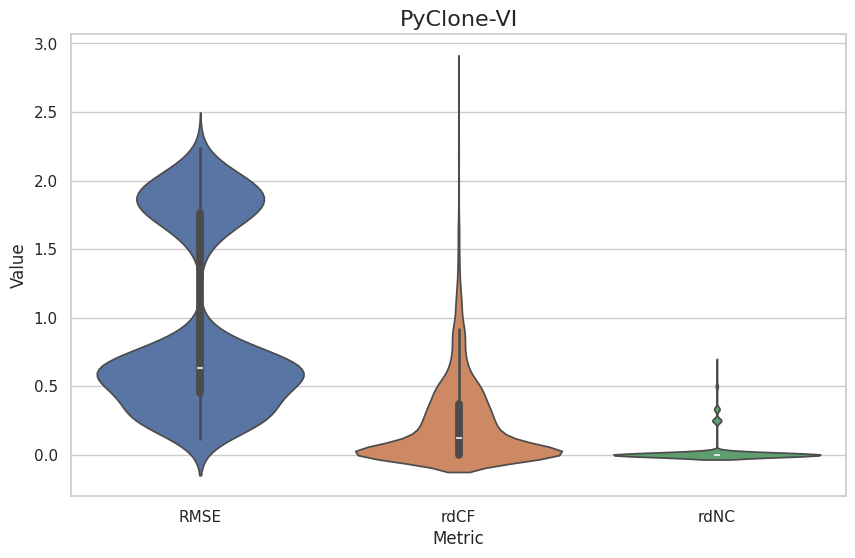

In [7]:
# Select the columns you want to plot
cols_to_plot = ['RMSE', 'rdCF', 'rdNC']

# Set the style
sns.set_theme(style="whitegrid")

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Create the violin plot
# Seaborn can directly take the specific columns of the dataframe
sns.violinplot(data=df[cols_to_plot])

# Add titles and labels for clarity
plt.title('PyClone-VI', fontsize=16)
plt.ylabel('Value')
plt.xlabel('Metric')

# Show the plot
plt.show()